インポート

In [3]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame, Series
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")

In [4]:
# Kaggle 上で動いているかどうかの判定
ON_KAGGLE = ("KAGGLE_KERNEL_RUN_TYPE" in os.environ) or Path("/kaggle/input").exists()

if ON_KAGGLE:
    PATH_DATA = "kaggle/input/titanic"
else:
    PATH_DATA = "data"

PATH_TRAIN_CSV = os.path.join(PATH_DATA, "train.csv")
PATH_TEST_CSV = os.path.join(PATH_DATA, "test.csv")

df = pd.read_csv(PATH_TRAIN_CSV)
df_test = pd.read_csv(PATH_TEST_CSV)

print(df.shape)

(891, 12)


## データの概要

In [66]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,C,Q,S
0,1,0,3,0,22.0,1,0,7.2500,S,False,False,True
1,2,1,1,1,38.0,1,0,71.2833,C,True,False,False
2,3,1,3,1,26.0,0,0,7.9250,S,False,False,True
3,4,1,1,1,35.0,1,0,53.1000,S,False,False,True
4,5,0,3,0,35.0,0,0,8.0500,S,False,False,True


In [8]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [51]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

生存者の割合

<Axes: xlabel='Survived', ylabel='count'>

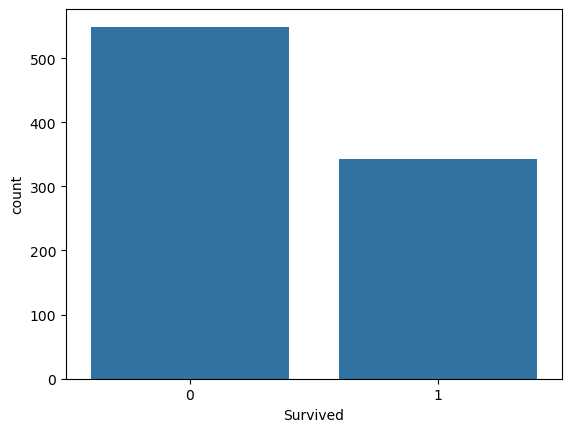

In [22]:
sns.countplot(x="Survived", data=df)

性別の割合

<Axes: xlabel='Sex', ylabel='count'>

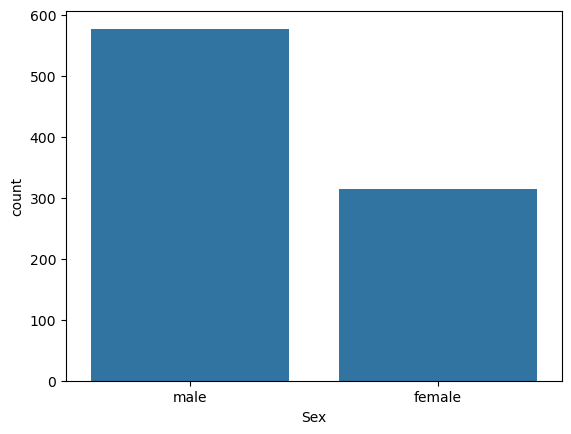

In [23]:
sns.countplot(x="Sex", data=df)

チケットのクラス

PClassが大きいほど生存率が低い

<Axes: xlabel='Pclass', ylabel='count'>

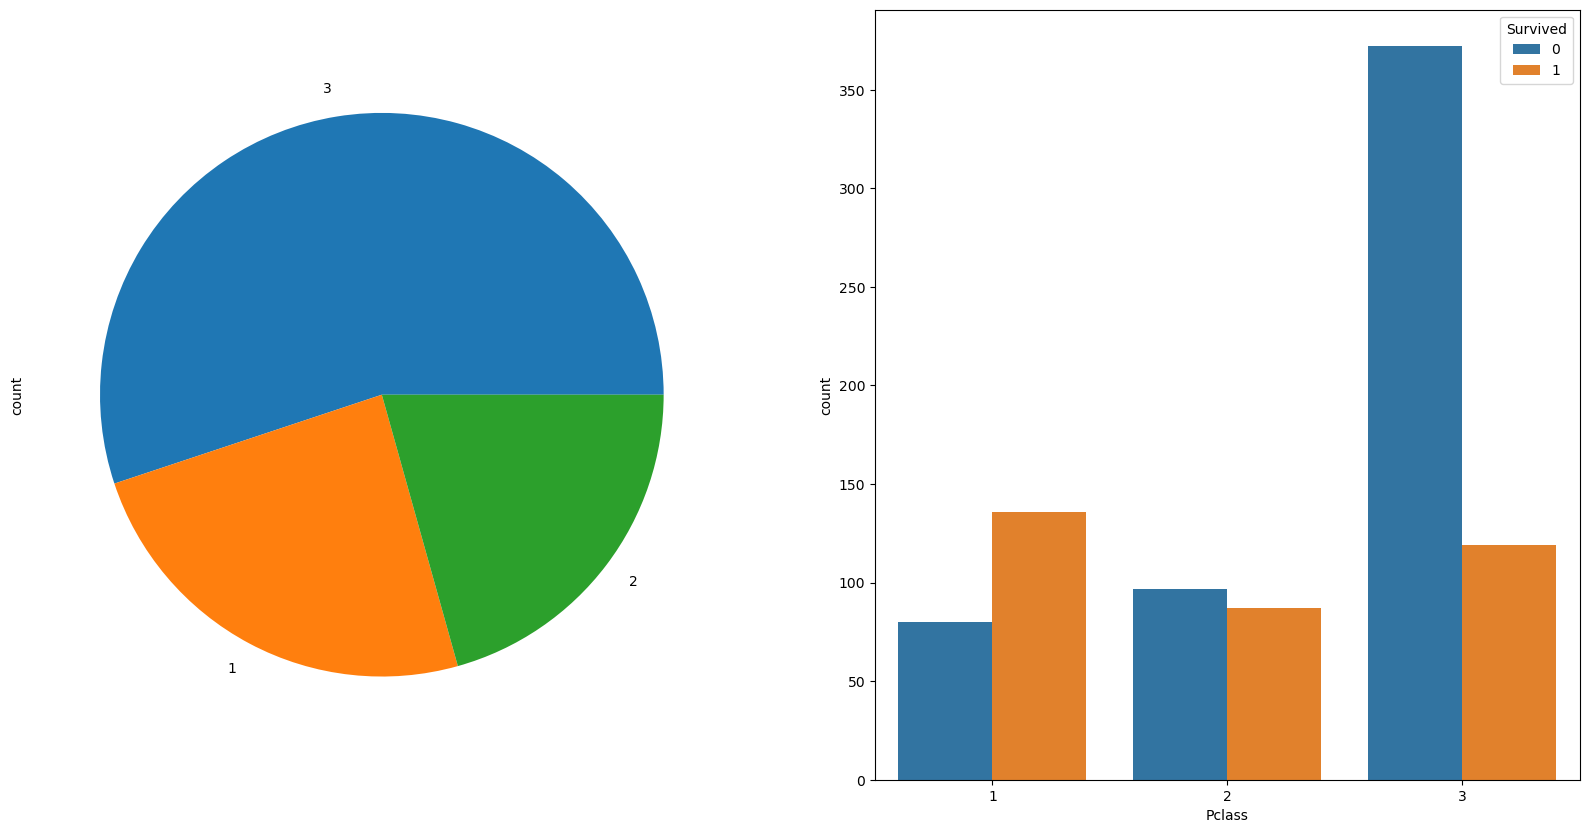

In [34]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))
df["Pclass"].value_counts().plot.pie(ax=ax[0])
sns.countplot(x="Pclass", hue="Survived", data=df, ax=ax[1])

年齢毎の生存率

<Axes: xlabel='Sex', ylabel='Age'>

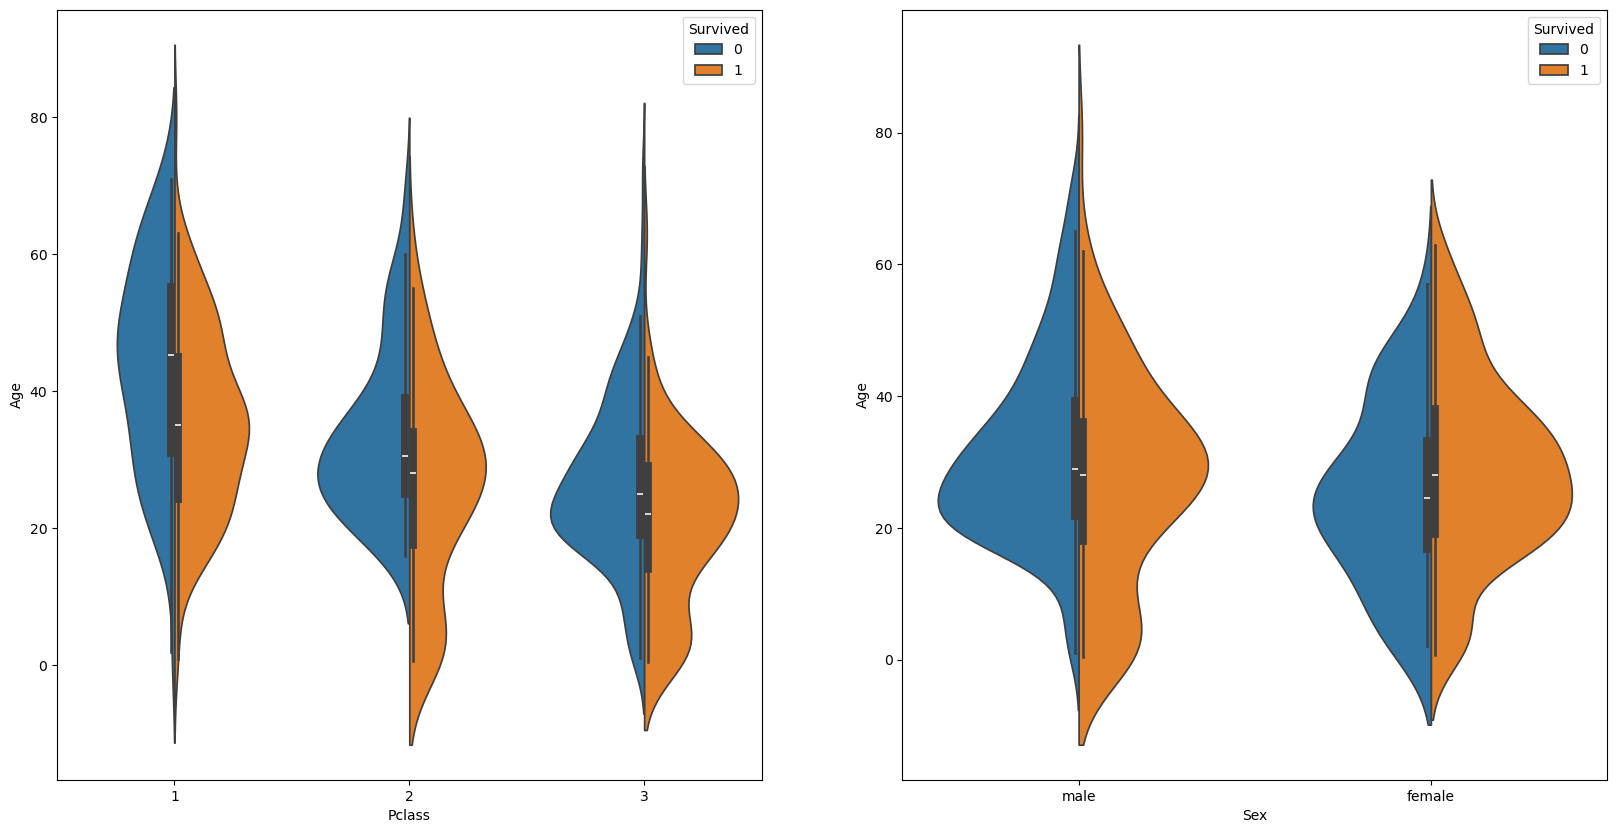

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=df, split=True, ax=ax[0])
sns.violinplot(x="Sex", y="Age", hue="Survived", data=df, split=True, ax=ax[1])

### ヒートマップ

<Axes: >

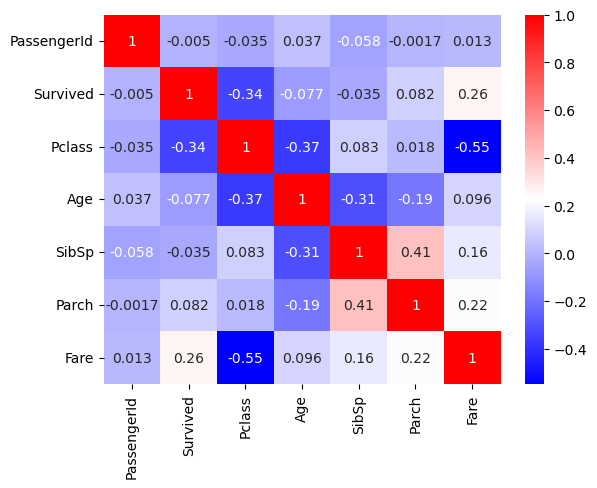

In [50]:
df_numeric = df.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(), annot=True, cmap="bwr")

## データの前処理

欠損値の補間

age と fare の欠損値を平均値で補間

In [53]:
age = pd.concat([df["Age"], df_test["Age"]])
fare = pd.concat([df["Fare"], df_test["Fare"]])

df["Age"].fillna(age.mean(), inplace=True)
df_test["Age"].fillna(age.mean(), inplace=True)

df["Fare"].fillna(fare.mean(), inplace=True)
df_test["Fare"].fillna(fare.mean(), inplace=True)

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cabin は欠損値が多いので、削除する

In [54]:
df.drop("Cabin", axis=1, inplace=True)
df_test.drop("Cabin", axis=1, inplace=True)

df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

Emberked は最頻値で補間

<Axes: xlabel='Embarked', ylabel='count'>

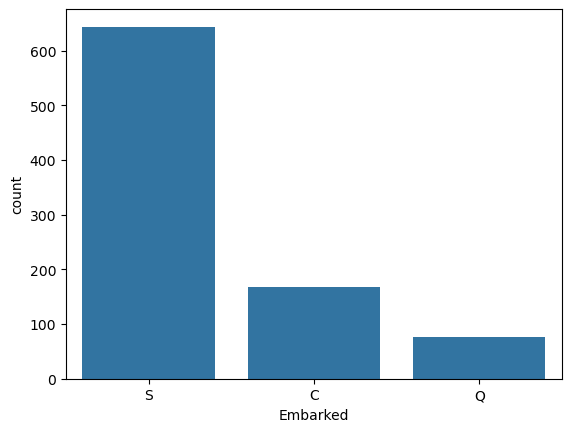

In [56]:
sns.countplot(x="Embarked", data=df)

In [57]:
df["Embarked"].fillna("S", inplace=True)
df_test["Embarked"].fillna("S", inplace=True)

df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### カテゴリカルデータに対する処理

一旦種類の多い Name と Ticket は削除する

In [58]:
df.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)

df.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

性別(Sex)に関して

In [59]:
df.replace({"Sex": {"male": 0, "female": 1}}, inplace=True)
df_test.replace({"Sex": {"male": 0, "female": 1}}, inplace=True)

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,S
1,2,1,1,1,38.0,1,0,71.2833,C
2,3,1,3,1,26.0,0,0,7.9250,S
3,4,1,1,1,35.0,1,0,53.1000,S
4,5,0,3,0,35.0,0,0,8.0500,S


Embarked をワンホットエンコーディングする

In [73]:
embarked = pd.concat([df["Embarked"], df_test["Embarked"]])

embarked_ohe = pd.get_dummies(embarked)

embarked_ohe_train = embarked_ohe[:891]
embarked_ohe_test = embarked_ohe[891:]

df = pd.concat([df, embarked_ohe_train], axis=1)
df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

df.drop("Embarked", axis=1, inplace=True)
df_test.drop("Embarked", axis=1, inplace=True)

df.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S,C,Q,S
0,1,0,3,0,22.0,1,0,7.2500,False,False,True,False,False,True
1,2,1,1,1,38.0,1,0,71.2833,True,False,False,True,False,False
2,3,1,3,1,26.0,0,0,7.9250,False,False,True,False,False,True
3,4,1,1,1,35.0,1,0,53.1000,False,False,True,False,False,True
4,5,0,3,0,35.0,0,0,8.0500,False,False,True,False,False,True


## モデル構築

In [74]:
x = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

x_test = df_test.iloc[:, 1:].values

データの分割

In [75]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=42)

ランダムフォレスト

In [79]:
rfc = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(x_train, y_train)

acc = round(rfc.score(x_train, y_train), 3)
acc_valid = round(rfc.score(x_valid, y_valid), 3)

print(f"Train Score: {acc}")
print(f"Valid Score: {acc_valid}")

Train Score: 0.952
Valid Score: 0.776


グリッドサーチによるハイパーパラメータチューニング

In [80]:
param_grid = {"max_depth": [1, 3, 5, 7, 9], "min_samples_leaf": [1, 2, 3, 4, 5]}

for max_depth in param_grid["max_depth"]:
    for min_samples_leaf in param_grid["min_samples_leaf"]:
        rfc_grid = RandomForestClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            n_estimators=100,
            n_jobs=-1,
            random_state=42,
        )

        rfc_grid.fit(x_train, y_train)
        print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}")
        print(f"\tTrain Score: {round(rfc_grid.score(x_train, y_train), 3)}")
        print(f"\tValid Score: {round(rfc_grid.score(x_valid, y_valid), 3)}")

max_depth: 1, min_samples_leaf: 1
	Train Score: 0.788
	Valid Score: 0.772
max_depth: 1, min_samples_leaf: 2
	Train Score: 0.788
	Valid Score: 0.772
max_depth: 1, min_samples_leaf: 3
	Train Score: 0.788
	Valid Score: 0.772
max_depth: 1, min_samples_leaf: 4
	Train Score: 0.788
	Valid Score: 0.772
max_depth: 1, min_samples_leaf: 5
	Train Score: 0.788
	Valid Score: 0.772
max_depth: 3, min_samples_leaf: 1
	Train Score: 0.838
	Valid Score: 0.802
max_depth: 3, min_samples_leaf: 2
	Train Score: 0.835
	Valid Score: 0.802
max_depth: 3, min_samples_leaf: 3
	Train Score: 0.83
	Valid Score: 0.799
max_depth: 3, min_samples_leaf: 4
	Train Score: 0.83
	Valid Score: 0.806
max_depth: 3, min_samples_leaf: 5
	Train Score: 0.83
	Valid Score: 0.806
max_depth: 5, min_samples_leaf: 1
	Train Score: 0.859
	Valid Score: 0.802
max_depth: 5, min_samples_leaf: 2
	Train Score: 0.848
	Valid Score: 0.799
max_depth: 5, min_samples_leaf: 3
	Train Score: 0.857
	Valid Score: 0.802
max_depth: 5, min_samples_leaf: 4
	Train 

クロスバリデーション + グリッドサーチ

In [81]:
rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), param_grid, cv=5)
rfc_gs.fit(x_train, y_train)

print(f"Best Parameters: {rfc_gs.best_params_}")
print(f"CV Score: {round(rfc_gs.best_score_, 3)}")

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4}
CV Score: 0.835


## 特徴量エンジニアリング

SibSp と Parch を合算して FamilySize を作成

In [84]:
df_fe = df.copy()
df_fe_test = df_test.copy()

df_fe["FamilySize"] = df["SibSp"] + df["Parch"]
df_fe_test["FamilySize"] = df_test["SibSp"] + df["Parch"]

df_fe.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S,C,Q,S,FamilySize
0,1,0,3,0,22.0,1,0,7.2500,False,False,True,False,False,True,1
1,2,1,1,1,38.0,1,0,71.2833,True,False,False,True,False,False,1
2,3,1,3,1,26.0,0,0,7.9250,False,False,True,False,False,True,0
3,4,1,1,1,35.0,1,0,53.1000,False,False,True,False,False,True,1
4,5,0,3,0,35.0,0,0,8.0500,False,False,True,False,False,True,0


再度学習

In [91]:
x_fe = df_fe.iloc[:, 2:].values
y_fe = df_fe.iloc[:, 1].values

x_fe_test = df_fe_test.iloc[:, 1:].values

x_fe_train, x_fe_valid, y_fe_train, y_fe_valid = train_test_split(x_fe, y_fe, test_size=0.3, random_state=42)

rfc_fe = RandomForestClassifier(max_depth=5, min_samples_leaf=4, n_estimators=100, n_jobs=-1, random_state=42)
rfc_fe.fit(x_fe_train, y_fe_train)

print(f"Train Score: {round(rfc_fe.score(x_fe_train, y_fe_train), 3)}")
print(f"Valid Score: {round(rfc_fe.score(x_fe_valid, y_fe_valid), 3)}")

Train Score: 0.854
Valid Score: 0.799


### 他の学習モデル

ロジスティック回帰

In [92]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)

print(f"Train Score: {round(lr.score(x_train, y_train), 3)}")
print(f"Valid Score: {round(lr.score(x_valid, y_valid), 3)}")

Train Score: 0.799
Valid Score: 0.813


多層パーセプトロン

In [93]:
mlpc = MLPClassifier(hidden_layer_sizes=(100, 100, 10), random_state=0)
mlpc.fit(x_train, y_train)

print(f"Train Score: {round(mlpc.score(x_train, y_train), 3)}")
print(f"Valid Score: {round(mlpc.score(x_valid, y_valid), 3)}")

Train Score: 0.785
Valid Score: 0.769


### アンサンブル

ランダムフォレスト、ロジスティック回帰、多層パーセプトロンの予測をアンサンブルして最終予測を行う

In [99]:
rfc_pred = rfc.predict_proba(x_test)
lr_pred = lr.predict_proba(x_test)
mlpc_pred = mlpc.predict_proba(x_test)

pred_proba = (rfc_pred + lr_pred + mlpc_pred) / 3
pred = pred_proba.argmax(axis=1)

print(pred)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]


## 提出

In [98]:
submission = pd.read_csv(os.path.join(PATH_DATA, "gender_submission.csv"))
print(submission)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [95]:
pred.shape

(418,)

In [103]:
submission["Survived"] = pred
submission.to_csv("submission.csv", index=False)